# Umap Visualization

***🚀 If you haven’t signed up for LanceDB Cloud yet, click [here](https://cloud.lancedb.com) to get started!***

## What is UMAP and Why Should You Care?

Imagine you have a messy closet with hundreds of items scattered around. It's hard to see patterns or find what you need. Now imagine organizing everything onto a simple table where similar items are grouped
together - suddenly you can see relationships and make sense of your belongings.

UMAP (Uniform Manifold Approximation and Projection) does something similar for data. It takes complex datasets with hundreds or thousands of dimensions
- think of these as having hundreds of different characteristics
- and creates a simple 2D or 3D map that you can actually look at and understand.

## Why is this useful?

When working with AI and machine learning, we often deal with vector embeddings - these are just numerical representations of things like words, images, or documents. But these vectors typically have hundreds of dimensions, making them impossible to visualize directly.

## UMAP helps by:
- Making the invisible visible: Transforming complex data into something you can see
- Preserving relationships: Items that were similar in the original data stay close together on the map
- Revealing patterns: Clusters, outliers, and trends become obvious once visualized

## What You'll Learn

In this notebook, we'll walk you through the process of taking high-dimensional vector embeddings and creating beautiful, informative 2D and 3D visualizations that reveal hidden patterns in your data.

# Step 1: Install Required Libraries

In [ ]:
!pip install lancedb pandas umap-learn

In [ ]:
import pandas as pd
import umap
import lancedb
from google.colab import userdata

# Step 2: Obtain the API key from the [dashboard](https://cloud.lancedb.com)

* Get the db uri

`db uri` starts with `db://`, which can be obtained from the project page on the dashboard. In the following example, `db uri` is `db://test-sfifxz`.
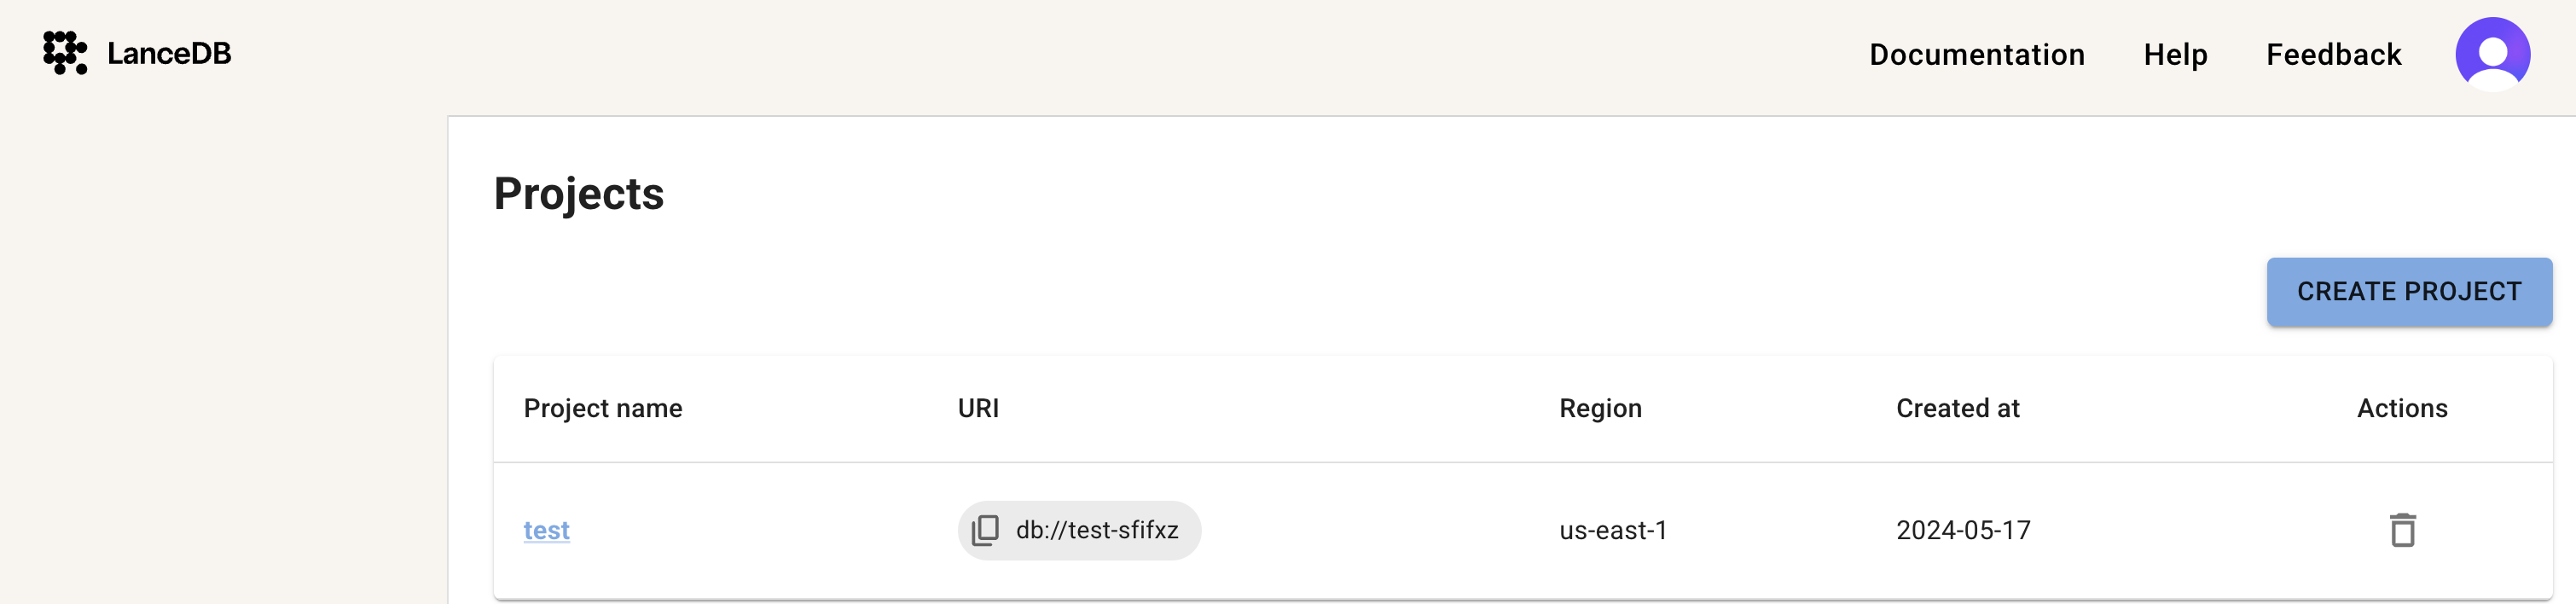

* Get the API Key Obtain a LanceDB Cloud API key by clicking on the GENERATE API KEY from the table page.

💡 Copy the code block for connecting to LanceDB Cloud that is shown at the last step of API key generation.
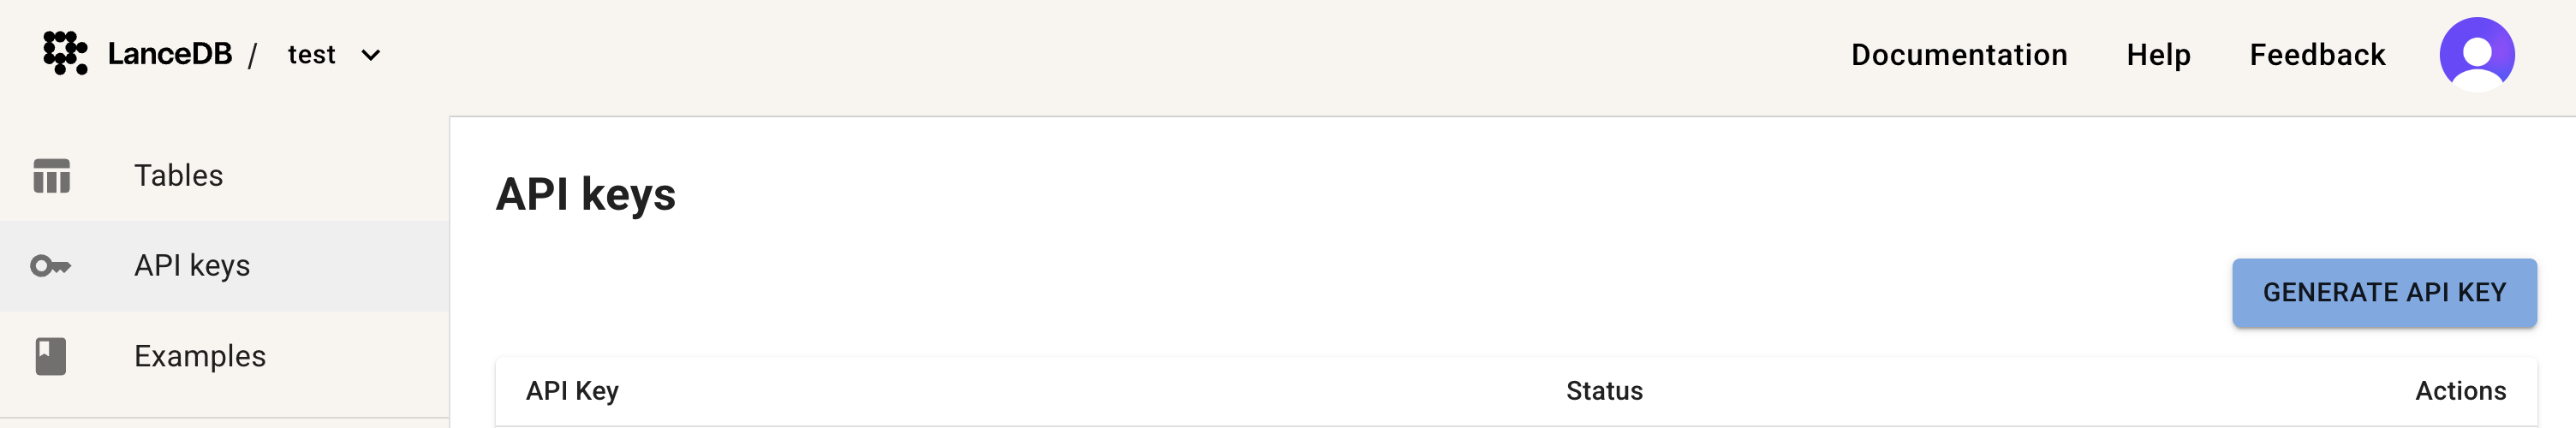

In [ ]:
uri = ""  # @param {type:"string"}
api_key = "sk_..."  # @param { type:"string"}

You can adjust these umap parameters. checkout https://umap-learn.readthedocs.io/en/latest/parameters.html#metric for more details.

In [ ]:
# See
umap_metric = "cosine"  # @param{type:"string"}

umap_n_neighbors = 15  # @param{type:"number"}

# Number of UMAP dimensions. We support either 2 or 3.
umap_n_components = 2  # @param{type:"number"}

# Step 3: Copy the dataset

We prepared a `people` dataset for demo purposes and you can use your own dataset.

In [ ]:
!wget https://vectordb-recipes.s3.us-west-2.amazonaws.com/people.lance.tgz
!tar -zxvf people.lance.tgz
!mkdir -p data/people-lancedb
!mv people.lance data/people-lancedb

In [ ]:
# This table has embeddings, but not umap data.
source_db = lancedb.connect("data/people-lancedb")
source_table = source_db.open_table("people")
source_data = source_table.search().to_arrow()
schema = source_table.schema

target_db = lancedb.connect(uri=uri, api_key=api_key, region="us-east-1")

# The name of the remote table where the source table is copied
# and UMAP data is appended.
table_name = "people"  # @param {type:"string"}

# Create a remote table with the downloaded dataset.
target_table = target_db.create_table(table_name, schema=schema, data=[])

batch_size = 100
offset = 0

while True:
    batch = source_table.search().limit(batch_size).offset(offset).to_arrow()

    if len(batch) == 0:
        break

    target_table.add(batch)

    offset += batch_size
    print(f"Transferred {offset} rows...")

print("✅ Transfer complete!")

# Step 4: Adding umap

In [ ]:
table = target_db.open_table(table_name)

vector_column_name = "vector"
umap_column_name = f"_{vector_column_name}_umap"
table.add_columns(
    {
        umap_column_name: f"arrow_cast(NULL, 'FixedSizeList({umap_n_components}, Float32)')"
    }
)
print(f"✅ Added {umap_column_name} column")

id_column_name = "id"

# Extracts all vectors and their corresponding IDs from the table.
# UMAP needs the raw vector data to learn the high-dimensional structure before
# it can create the lower-dimensional representation (2D/3D map).
results = table.search(None).select([vector_column_name, id_column_name]).to_list()
vectors = [row[vector_column_name] for row in results]
ids = [row[id_column_name] for row in results]

umap_model = umap.UMAP(
    n_components=umap_n_components,
    n_neighbors=umap_n_neighbors,
    metric=umap_metric,
    n_epochs=100,
)
# Note we are fitting the entire vector column here. In this simple example, it works fine.
# But if your table is much longer, you must take a small sample of all the vectors randomly selected,
# Perform the fit_transform operation on the sample before applying to the entire vector column.
sampled_vectors = vectors
umap_result = umap_model.fit_transform(sampled_vectors)

# If sampled_vectors is different from all the vectors, uncomment the next line.
# umap_result = umap_model.transform(vectors)

umap_df = pd.DataFrame(
    {id_column_name: ids, umap_column_name: [vec.tolist() for vec in umap_result]}
)

# Create a clean DataFrame with the original IDs and their new UMAP coordinates.
# Each vector that was originally high-dimensional is now represented as a 2D or 3D point.
table.merge_insert(
    id_column_name
).when_matched_update_all().when_not_matched_insert_all().execute(umap_df)

print(f"✅ Completed UMAP projection and insertion for {table_name}")

# Step 5: Visualize the data in the Clustering tab



In [ ]:
# open the URL below
project_slug = uri.replace("db://", "")
url = (
    f"https:cloud.lancedb.com/dashboard/projects/{project_slug}/tables/{table_name}#viz"
)
print(url)